In [3]:
from nptdms import TdmsFile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime


path = r"E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Patients ePatch data\Patient 5\recording 1\Patient 5_1.tdms"

from nptdms import TdmsFile
import pandas as pd
import numpy as np
import arrow

def process_tdms_file(tdms_path):
    """
    Process a TDMS file to extract the raw ECG signal and metadata.

    Parameters:
        tdms_path (str): Path to the TDMS file.

    Returns:
        tuple: A tuple containing:
            - ecg_raw (numpy.ndarray): The raw ECG signal as a float numpy array.
            - metadata_df (pandas.DataFrame): A dataframe containing metadata for all channels.
    """

    # Read the TDMS file
    tdms_file = TdmsFile.read(tdms_path)

    # Select the first group and its channels
    channel1 = tdms_file.groups()[0]
    channels = channel1.channels()

    # Select the ECG channel if present, otherwise take the first channel
    ecg_channel = next((ch for ch in channels if ch.name.lower() == 'ekg'), channels[0])

    # Load raw ECG samples as a float numpy array
    ecg_raw = ecg_channel.data.astype(float)

    # Collect metadata for all channels
    metadata = []
    for group in tdms_file.groups():
        for channel in group.channels():
            for prop_name, prop_value in channel.properties.items():
                if prop_name.lower() in ['wf_start_time', 'ni_expisrelativetime', 'ni_exptimestamp']:
                    try:
                        corrected_time = arrow.get(prop_value.astype(datetime.datetime)).to('local')
                        formatted_time = corrected_time.format()
                    except Exception as e:
                        formatted_time = f"Error: {e}"
                    metadata.append({
                        "Group": group.name,
                        "Channel": channel.name,
                        "Property": prop_name,
                        "Value": formatted_time
                    })
                else:
                    metadata.append({
                        "Group": group.name,
                        "Channel": channel.name,
                        "Property": prop_name,
                        "Value": prop_value
                    })

    # Convert metadata to a pandas DataFrame
    metadata_df = pd.DataFrame(metadata)

    return ecg_raw, metadata_df

In [4]:
x, meta = process_tdms_file(path)
print(meta)

       Group Channel              Property  \
0   Untitled     EKG         wf_start_time   
1   Untitled     EKG       wf_start_offset   
2   Untitled     EKG          wf_increment   
3   Untitled     EKG            wf_samples   
4   Untitled     EKG        DigitalMaximum   
5   Untitled     EKG        DigitalMinimum   
6   Untitled     EKG        NI_ChannelName   
7   Untitled     EKG  NI_ExpIsRelativeTime   
8   Untitled     EKG          wf_time_pref   
9   Untitled     EKG  NI_ExpStartTimeStamp   
10  Untitled     EKG       NI_ExpTimeStamp   
11  Untitled     EKG      NI_ExpXDimension   
12  Untitled     EKG              wf_xname   
13  Untitled     EKG       wf_xunit_string   
14  Untitled     EKG    NI_UnitDescription   
15  Untitled     EKG           unit_string   
16  Untitled     EKG       PhysicalMaximum   
17  Untitled     EKG       PhysicalMinimum   
18  Untitled     EKG             PreFilter   
19  Untitled     EKG        TransducerType   
20  Untitled     EKG            Va

In [5]:
import numpy as np
from dataclasses import dataclass
from typing import Optional, Dict, Any, Tuple
from scipy.signal import remez, filtfilt

# -------- helper: 8-point moving average (med spejl-padding for pæn kant) --------
def _moving_average_8(x: np.ndarray) -> np.ndarray:
    w = 8
    if len(x) < w + 2:
        return x.copy()
    kernel = np.ones(w, dtype=float) / w
    pad = w
    xpad = np.r_[x[pad:0:-1], x, x[-2:-pad-2:-1]]
    y = np.convolve(xpad, kernel, mode="same")[pad:-pad]
    return y

# -------- helper: konservativt kanttrim pga. filtfilt + FIR --------
def _edge_trim_seconds(fs: float, taps_hp: int, taps_lp: int, smooth_len: int = 8) -> float:
    # filtfilt fordobler den effektive kant; læg lille sikkerhed på
    half_hp = (taps_hp - 1) / 2
    half_lp = (taps_lp - 1) / 2
    half_sm = (smooth_len - 1) / 2
    edge_samples = int(np.ceil((half_hp + half_lp + half_sm) * 2 * 1.2))
    return edge_samples / fs

@dataclass
class JeppesenParams:
    sampling_rate: float = 512.0  # ePatch
    # Equiripple højpas (HP): stop 0–1 Hz, pass fra 30 Hz, 33 taps (ordre 32)
    hp_stop_hz: float = 1.0
    hp_pass_hz: float = 30.0
    taps_hp: int = 33
    # Equiripple lavpas (LP): pass 0–32 Hz, stop fra 50 Hz, 32 taps (ordre 31)
    lp_pass_hz: float = 32.0
    lp_stop_hz: float = 50.0
    taps_lp: int = 32
    # Efterbehandling
    use_smoothing: bool = True     # 8-punkts glidende middel
    # Kanttrim i plots/analyse (påvirker ikke selve filtreringen)
    edge_trim_s: Optional[float] = None  # None => auto baseret på taps

def ecg_clean_jeppesen(signal: np.ndarray,
                       sampling_rate: Optional[float] = None,
                       return_all: bool = False,
                       params: Optional[JeppesenParams] = None
                       ) -> np.ndarray | Dict[str, Any]:
    """
    Jeppesen et al. (IEEE, 2017) ECG 'filtering/enhancement' pipeline:
        1) Equi-ripple FIR high-pass: stop 0–1 Hz, pass >= 30 Hz, 33 taps
        2) Equi-ripple FIR low-pass: pass 0–32 Hz, stop >= 50 Hz, 32 taps
        3) 8-point moving average smoothing
    Ingen absolutværdi før R-peak-detektion.

    Parameters
    ----------
    signal : array
        Rå ECG.
    sampling_rate : float, optional
        Hz. Default hentes fra params (512 Hz).
    return_all : bool
        True => returnér dict med mellemtrin og meta.
    params : JeppesenParams
        Finjusteringer (taps, grænser, edge trim m.m.)

    Returns
    -------
    cleaned : array (eller dict hvis return_all=True)
    """
    x = np.asarray(signal, dtype=float)
    p = params or JeppesenParams()
    fs = float(sampling_rate if sampling_rate is not None else p.sampling_rate)

    # --- High-pass (equiripple) ---
    # Bands: [0, hp_stop] -> 0  |  [hp_pass, fs/2] -> 1
    # Brug højere weight i stopbåndet for bedre baseline-afvisning.
    bands_hp = [0.0, p.hp_stop_hz, p.hp_pass_hz, fs/2.0]
    desired_hp = [0, 1]
    weights_hp = [3, 1]  # prioriter baseline-fjernelse
    bhp = remez(p.taps_hp, bands_hp, desired_hp, weight=weights_hp, fs=fs)
    x_hp = filtfilt(bhp, [1.0], x)

    # --- Low-pass (equiripple) ---
    # Bands: [0, lp_pass] -> 1  |  [lp_stop, fs/2] -> 0
    bands_lp = [0.0, p.lp_pass_hz, p.lp_stop_hz, fs/2.0]
    desired_lp = [1, 0]
    weights_lp = [1, 3]  # prioriter stop over 50 Hz
    blp = remez(p.taps_lp, bands_lp, desired_lp, weight=weights_lp, fs=fs)
    x_lp = filtfilt(blp, [1.0], x_hp)

    # --- 8-point smoothing (valgfrit) ---
    x_sm = _moving_average_8(x_lp) if p.use_smoothing else x_lp

    # --- edge trim (til sammenlignelige plots/analyser) ---
    edge_s = p.edge_trim_s if p.edge_trim_s is not None else _edge_trim_seconds(fs, p.taps_hp, p.taps_lp, 8)
    k = int(round(edge_s * fs))
    if k > 0 and (len(x_sm) > 2*k):
        # Trimmer kun til QA/plot – selve filtreringen er fuld længde
        trimmed = x_sm[k:-k].copy()
    else:
        trimmed = x_sm.copy()

    if not return_all:
        return trimmed

    return {
        "cleaned": trimmed,
        "hp": x_hp,
        "lp": x_lp,
        "smoothed": x_sm,
        "fs": fs,
        "filters": {"bhp": bhp, "blp": blp},
        "edge_trim_s": edge_s
    }


In [6]:
import neurokit2 as nk
import matplotlib.pyplot as plt
import numpy as np

fs = 512  # sampling rate i Hz

clean_jepp = ecg_clean_jeppesen(x, sampling_rate=fs)               # Jeppesen
clean_elg  = nk.ecg_clean(x, sampling_rate=fs, method="elgendi2010")
clean_pt   = nk.ecg_clean(x, sampling_rate=fs, method="pantompkins1985")
clean_nk   = nk.ecg_clean(x, sampling_rate=fs, method="neurokit")

signals = {
    "raw": x,
    "jeppesen": clean_jepp,
    "elgendi2010": clean_elg,
    "pantompkins1985": clean_pt,
    "neurokit": clean_nk,
}


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Iterable, Optional, Tuple

def _safe_window(sig: np.ndarray, fs: float, start_s: float, dur_s: float, offset_s: float = 0.0) -> Tuple[np.ndarray, np.ndarray]:
    """Returnér (t, y) for et udsnit. offset_s forskyder signalet relativt (kan bruges til at align'e)."""
    n = len(sig)
    i0 = int(round((start_s - offset_s) * fs))
    i1 = i0 + int(round(dur_s * fs))
    i0c, i1c = max(0, i0), min(n, i1)
    if i1c <= i0c:
        return np.array([]), np.array([])
    y = sig[i0c:i1c]
    t = np.arange(i0c, i1c) / fs
    # lokal tid i vinduet (0 = vinduesstart)
    t = t - (start_s)
    return t, y

def plot_ecg_window(
    signals: Dict[str, np.ndarray],
    fs: float,
    start_s: float,
    dur_s: float = 8.0,
    which: Optional[Iterable[str]] = None,
    offsets_s: Optional[Dict[str, float]] = None,
    normalize: bool = False,
    title: Optional[str] = None,
    linewidth: float = 1.2,
):
    """
    Plot et VINDUE af udvalgte spor.
    - signals: dict {"navn": array}
    - fs: fælles sampling rate (Hz) for sporene (eller resample på forhånd)
    - which: liste over hvilke keys der skal plottes (default: alle i dict)
    - offsets_s: frivillige tidsforskydninger per spor (sek), fx {"labview":0.9}
    - normalize: hvis True, skaler hver kurve med egen std for bedre overlay
    """
    if which is None:
        which = list(signals.keys())
    offsets_s = offsets_s or {}

    plt.figure(figsize=(12,4))
    nplotted = 0
    for name in which:
        if name not in signals:
            continue
        off = float(offsets_s.get(name, 0.0))
        t, y = _safe_window(signals[name], fs, start_s, dur_s, offset_s=off)
        if len(y) == 0:
            continue
        yplot = (y - np.median(y)) / (np.std(y) + 1e-9) if normalize else y
        plt.plot(t, yplot, label=(f"{name} (offset {off:+.2f}s)" if abs(off) > 1e-6 else name), linewidth=linewidth)
        nplotted += 1

    if nplotted == 0:
        print("Ingen data i det valgte vindue.")
        return

    plt.axvline(0, color="k", alpha=0.2, linewidth=1)
    plt.axvline(dur_s, color="k", alpha=0.2, linewidth=1)
    plt.grid(True, alpha=0.3)
    plt.xlabel("Tid i vindue [s] (0 = vinduesstart)")
    plt.ylabel("Amplitude" + (" (z-score pr. spor)" if normalize else ""))
    plt.title(title or f"ECG vindue: start={start_s:.2f}s, varighed={dur_s:.2f}s")
    plt.legend()
    plt.show()


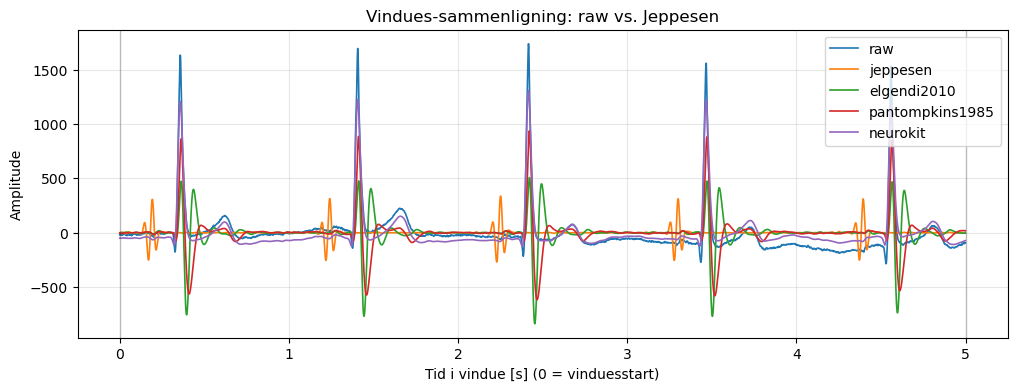

In [8]:
# Vælg fx et vindue ved 10000s af længde 30s
plot_ecg_window(signals, fs=fs, start_s=10000, dur_s=5,
                which=["raw","jeppesen", "elgendi2010", "pantompkins1985", "neurokit"],          # vælg kun de spor du vil se
                offsets_s={"jeppesen": 0.0},       # evt. manuel offset justering pr. spor
                normalize=False,
                title="Vindues-sammenligning: raw vs. Jeppesen")

Bedste lokale offset (jeppesen vs raw): +1.200s


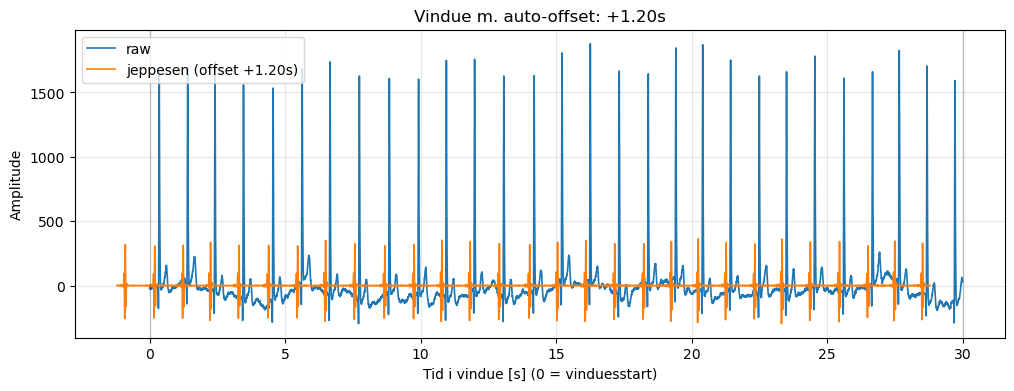

In [9]:
def best_offset_for_window(a: np.ndarray, b: np.ndarray, fs: float, start_s: float, dur_s: float,
                           offsets_to_try=np.linspace(-2.0, 2.0, 41)) -> float:
    """Find offset (sek) for b relativt til a, der minimerer MSE i vinduet."""
    t_a, ya = _safe_window(a, fs, start_s, dur_s, offset_s=0.0)
    if len(ya) == 0: return 0.0
    best = (0.0, np.inf)
    for off in offsets_to_try:
        t_b, yb = _safe_window(b, fs, start_s, dur_s, offset_s=off)
        if len(yb) != len(ya):  # match længde (simpel tilnærmelse)
            n = min(len(ya), len(yb))
            ya_c = ya[:n]; yb_c = yb[:n]
        else:
            ya_c = ya; yb_c = yb
        mse = np.mean((ya_c - yb_c)**2)
        if mse < best[1]:
            best = (off, mse)
    return best[0]

# Find offset for jeppesen relativt til raw i vinduet (10000s..10030s)
off = best_offset_for_window(signals["raw"], signals["jeppesen"], fs, start_s=10000, dur_s=30)
print(f"Bedste lokale offset (jeppesen vs raw): {off:+.3f}s")

plot_ecg_window(signals, fs=fs, start_s=10000, dur_s=30,
                which=["raw","jeppesen"],
                offsets_s={"jeppesen": off},
                title=f"Vindue m. auto-offset: {off:+.2f}s")


,nk_function,nk_quality,spec_snr_0.5-40_over_40+,baseline_ratio_0-0.5_over_0.5-40,kurtosis,std,median,n_samples
method,,,,,,,,
raw,nk.ecg_quality,"[0.9607423127289892, 0.9607423127289892, 0.960...",2.048012,2.318100e-01,8796.124895,669.872116,-45.469352,82460288
jeppesen,nk.ecg_quality,"[0.917134554893489, 0.917134554893489, 0.91713...",1362.034608,7.248353e-07,23832.617024,94.964847,0.060477,82460120
elgendi2010,nk.ecg_quality,"[0.5300122772559366, 0.5300122772559366, 0.530...",141.812461,5.422918e-06,13513.084398,245.934995,-0.234817,82460288
pantompkins1985,nk.ecg_quality,"[0.991787986561395, 0.991787986561395, 0.99178...",21.351801,8.872199e-04,11251.443450,306.746377,0.663851,82460288
neurokit,nk.ecg_quality,"[0.9299605860384091, 0.9299605860384091, 0.929...",24357.550909,6.748560e-03,11807.536228,443.774550,-48.909182,82460288



Descriptive statistics (numeric metrics):


,count,mean,std,min,25%,50%,75%,max
spec_snr_0.5-40_over_40+,5.0,5.176960e+03,10737.334913,2.048012e+00,2.135180e+01,1.418125e+02,1.362035e+03,2.435755e+04
baseline_ratio_0-0.5_over_0.5-40,5.0,4.789038e-02,0.102853,7.248353e-07,5.422918e-06,8.872199e-04,6.748560e-03,2.318100e-01
kurtosis,5.0,1.384016e+04,5835.912070,8.796125e+03,1.125144e+04,1.180754e+04,1.351308e+04,2.383262e+04
std,5.0,3.522586e+02,217.272675,9.496485e+01,2.459350e+02,3.067464e+02,4.437746e+02,6.698721e+02
median,5.0,-1.877780e+01,25.966516,-4.890918e+01,-4.546935e+01,-2.348171e-01,6.047672e-02,6.638508e-01
n_samples,5.0,8.246025e+07,75.131884,8.246012e+07,8.246029e+07,8.246029e+07,8.246029e+07,8.246029e+07



Ranking by spectral SNR (higher = cleaner in-band):


,spec_snr_0.5-40_over_40+,baseline_ratio_0-0.5_over_0.5-40,kurtosis,std,median,n_samples
method,,,,,,
neurokit,24357.550909,6.748560e-03,11807.536228,443.774550,-48.909182,82460288
jeppesen,1362.034608,7.248353e-07,23832.617024,94.964847,0.060477,82460120
elgendi2010,141.812461,5.422918e-06,13513.084398,245.934995,-0.234817,82460288
pantompkins1985,21.351801,8.872199e-04,11251.443450,306.746377,0.663851,82460288
raw,2.048012,2.318100e-01,8796.124895,669.872116,-45.469352,82460288


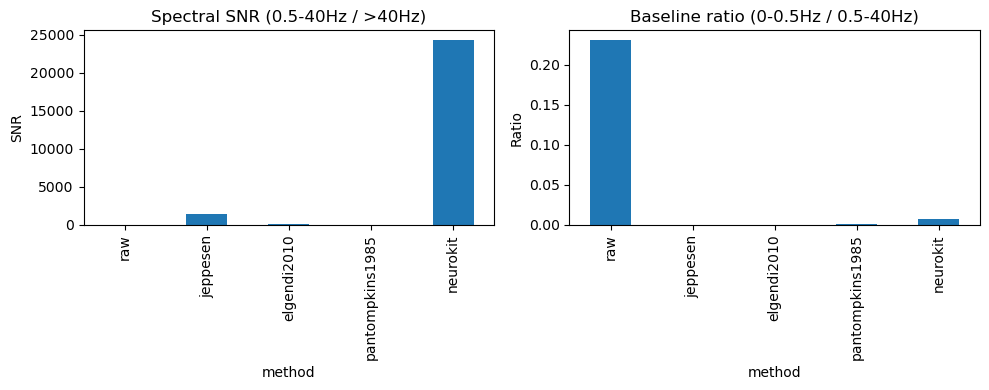

In [10]:
from scipy.signal import welch
from scipy.stats import kurtosis
import pandas as pd
import numpy as np

# Analyze signal quality for each method using NeuroKit2 (if available) + fallback spectral/kurtosis metrics
import matplotlib.pyplot as plt

# signals, fs and nk are available from previous cells
def _try_nk_quality(sig, fs):
    """Try a few NeuroKit2 quality entry points, return a numeric summary if possible."""
    candidates = []
    # common NeuroKit2 entry-points (try in a safe order)
    if hasattr(nk, "signal_quality"):
        candidates.append(("nk.signal_quality", lambda s: nk.signal_quality(s, sampling_rate=fs)))
    if hasattr(nk, "ecg_quality"):
        candidates.append(("nk.ecg_quality", lambda s: nk.ecg_quality(s, sampling_rate=fs)))
    # some NK versions expose quality under nk.signal_quality.quality (less common)
    try:
        sq_mod = nk.signal_quality
        if hasattr(sq_mod, "quality"):
            candidates.append(("nk.signal_quality.quality", lambda s: sq_mod.quality(s, sampling_rate=fs)))
    except Exception:
        pass

    for name, fn in candidates:
        try:
            res = fn(sig)
            # If res is a dict, try to extract a numeric field
            if isinstance(res, dict):
                # common keys to look for
                for k in ("quality", "signal_quality", "quality_index", "quality_score"):
                    if k in res:
                        v = res[k]
                        return name, float(v)
                # otherwise, if single numeric entry, take its first numeric value
                numeric_values = [float(v) for v in res.values() if isinstance(v, (int, float, np.floating, np.integer))]
                if len(numeric_values) == 1:
                    return name, float(numeric_values[0])
                # cannot reduce to single score -> return dict (non-numeric)
                return name, res
            # If it's a scalar
            if isinstance(res, (int, float, np.floating, np.integer, np.ndarray)):
                try:
                    return name, float(np.asarray(res).item())
                except Exception:
                    return name, res
        except Exception:
            continue
    return None, None

def spectral_metrics(sig, fs):
    nperseg = min(4096, len(sig))
    if nperseg < 8:
        return np.nan, np.nan
    f, Pxx = welch(sig, fs=fs, nperseg=nperseg)
    def band_power(f1, f2):
        mask = (f >= f1) & (f <= f2)
        if not np.any(mask):
            return 0.0
        return np.trapz(Pxx[mask], f[mask])
    p_baseline = band_power(0.0, 0.5)
    p_qrsband = band_power(0.5, 40.0)
    p_high = band_power(40.0, fs/2.0)
    spec_snr = p_qrsband / (p_high + 1e-12)
    baseline_ratio = p_baseline / (p_qrsband + 1e-12)
    return spec_snr, baseline_ratio

rows = []
for name, sig in signals.items():
    nk_name, nk_q = _try_nk_quality(sig, fs)
    spec_snr, baseline_ratio = spectral_metrics(sig, fs)
    k = kurtosis(sig, fisher=False, bias=False)  # Pearson's kurtosis
    std = float(np.std(sig))
    med = float(np.median(sig))
    rows.append({
        "method": name,
        "nk_function": nk_name,
        "nk_quality": nk_q,
        "spec_snr_0.5-40_over_40+": spec_snr,
        "baseline_ratio_0-0.5_over_0.5-40": baseline_ratio,
        "kurtosis": k,
        "std": std,
        "median": med,
        "n_samples": len(sig),
    })

df_q = pd.DataFrame(rows).set_index("method")
display(df_q)

# Summary statistics: numeric-only describe
numeric = df_q.select_dtypes(include=[np.number])
print("\nDescriptive statistics (numeric metrics):")
display(numeric.describe().T)

# Ranking by spectral SNR and (if available) NeuroKit quality numeric
print("\nRanking by spectral SNR (higher = cleaner in-band):")
display(numeric.sort_values("spec_snr_0.5-40_over_40+", ascending=False))

# If NeuroKit returned numeric qualities, show them sorted
if pd.api.types.is_numeric_dtype(df_q["nk_quality"]):
    print("\nRanking by NeuroKit quality (higher = better if numeric):")
    display(df_q["nk_quality"].sort_values(ascending=False))

# Quick visualization
fig, ax = plt.subplots(1,2, figsize=(10,4))
numeric["spec_snr_0.5-40_over_40+"].plot.bar(ax=ax[0], title="Spectral SNR (0.5-40Hz / >40Hz)", ylabel="SNR")
numeric["baseline_ratio_0-0.5_over_0.5-40"].plot.bar(ax=ax[1], title="Baseline ratio (0-0.5Hz / 0.5-40Hz)", ylabel="Ratio")
plt.tight_layout()
plt.show()

In [11]:
import numpy as np
import pandas as pd
from scipy.signal import welch

# ---------- helpers ----------
def _band_power_welch(sig, fs, f1, f2, nperseg=None):
    nperseg = nperseg or min(4096, len(sig))
    if nperseg < 8:
        return np.nan
    f, Pxx = welch(sig, fs=fs, nperseg=nperseg)
    mask = (f >= f1) & (f <= f2)
    if not np.any(mask):
        return 0.0
    return np.trapz(Pxx[mask], f[mask])

def _flatline_pct(sig, eps=None):
    # procent af samples hvor |diff|≈0 i forhold til signalets std
    s = np.std(sig)
    if s == 0:
        return 100.0
    eps = eps or (1e-9 + 1e-6 * s)
    d = np.abs(np.diff(sig))
    return 100.0 * np.mean(d < eps)

def _clipping_pct(sig, q=0.001, tol=0.0):
    # procent af samples ved "saturation" (nær min/max). Robust via percentiler.
    lo = np.quantile(sig, q)
    hi = np.quantile(sig, 1 - q)
    return 100.0 * (np.mean(sig <= lo + tol) + np.mean(sig >= hi - tol))

def _zscore(x, lo, hi):
    # map [lo..hi] -> [0..1] med clipping
    if np.isnan(x):
        return 0.0
    if lo == hi:
        return 0.0
    y = (x - lo) / (hi - lo)
    return float(np.clip(y, 0.0, 1.0))

def _invscore(x, lo, hi):
    # lav ratio -> god (1), høj -> dårlig (0)
    return 1.0 - _zscore(x, lo, hi)

# ---------- hovedfunktion ----------
def ecg_sqi(signal, fs, bands=(0.5, 40.0), high_band=(40.0, None), baseline_band=(0.0, 0.5),
            line_band=(49.0, 51.0), weights=None, return_dict=True):
    """
    ECG Signal Quality Index (0..1). Højere = bedre.
    Komponenter:
      - spec_snr = P(0.5-40) / P(>40)
      - baseline_ratio = P(0-0.5) / P(0.5-40)
      - line_ratio = P(49-51) / P(0.5-40)   (tilpas hvis fs != 50Hz-miljø)
      - flatline_pct = procent “næsten uændrede” samples
      - clipping_pct = procent ved min/max (robust)
    """
    x = np.asarray(signal, float)
    f_lo, f_hi = bands
    f_hi_high = fs/2.0 if high_band[1] is None else high_band[1]

    p_inband  = _band_power_welch(x, fs, f_lo, f_hi)
    p_high    = _band_power_welch(x, fs, high_band[0], f_hi_high)
    p_base    = _band_power_welch(x, fs, baseline_band[0], baseline_band[1])
    p_line    = _band_power_welch(x, fs, line_band[0], line_band[1])

    spec_snr       = p_inband / (p_high + 1e-12)
    baseline_ratio = p_base   / (p_inband + 1e-12)
    line_ratio     = p_line   / (p_inband + 1e-12)
    flat_pct       = _flatline_pct(x)
    clip_pct       = _clipping_pct(x)

    # --- normalisering til del-scorer [0..1] ---
    # tærskler er praktiske defaults; tilpas gerne efter dine data
    sc_snr   = _zscore(np.log10(spec_snr + 1e-12), lo=0.0,  hi=3.0)      # 10^0..10^3  => 1..1000
    sc_base  = _invscore(baseline_ratio,            lo=0.00, hi=0.05)     # <5% baseline ift. inband er godt
    sc_line  = _invscore(line_ratio,                lo=0.00, hi=0.02)     # <2% net-støj ift. inband er godt
    sc_flat  = _invscore(flat_pct/100.0,            lo=0.00, hi=0.01)     # <1% “flatline” er godt
    sc_clip  = _invscore(clip_pct/100.0,            lo=0.00, hi=0.005)    # <0.5% clipping er godt

    comps = {
        "SNR": sc_snr,
        "Baseline": sc_base,
        "LineNoise": sc_line,
        "Flatline": sc_flat,
        "Clipping": sc_clip,
    }

    # standardvægte (summerer til 1)
    weights = weights or {"SNR":0.40, "Baseline":0.20, "LineNoise":0.15, "Flatline":0.15, "Clipping":0.10}
    wsum = sum(weights.get(k,0) for k in comps)
    if wsum <= 0:
        weights = {k: 1/len(comps) for k in comps}
        wsum = 1.0
    score = float(sum(weights[k]*comps[k] for k in comps) / wsum)

    if not return_dict:
        return score

    return {
        "score": score,
        "components": comps,
        "weights": weights,
        "metrics": {
            "spec_snr": spec_snr,
            "baseline_ratio": baseline_ratio,
            "line_ratio": line_ratio,
            "flatline_pct": flat_pct,
            "clipping_pct": clip_pct,
        }
    }


,SQI,c_SNR,c_Baseline,c_LineNoise,c_Flatline,c_Clipping,spec_snr,baseline_ratio,line_ratio,flatline_pct,clipping_pct
method,,,,,,,,,,,
jeppesen,0.957722,1.000000,0.999986,0.999928,0.984910,0.599996,1362.034608,7.248353e-07,1.438471e-06,0.015090,0.200002
neurokit,0.922805,1.000000,0.865029,0.999988,0.932012,0.599997,24357.550909,6.748560e-03,2.446409e-07,0.067988,0.200002
elgendi2010,0.796965,0.717238,0.999892,0.693481,0.973800,0.599997,141.812461,5.422918e-06,6.130372e-03,0.026200,0.200002
pantompkins1985,0.579673,0.443145,0.982256,0.000000,0.973093,0.599997,21.351801,8.872199e-04,4.092213e-02,0.026907,0.200002
raw,0.101447,0.103778,0.000000,0.000000,0.000000,0.599361,2.048012,2.318100e-01,3.928521e-01,28.080895,0.200319


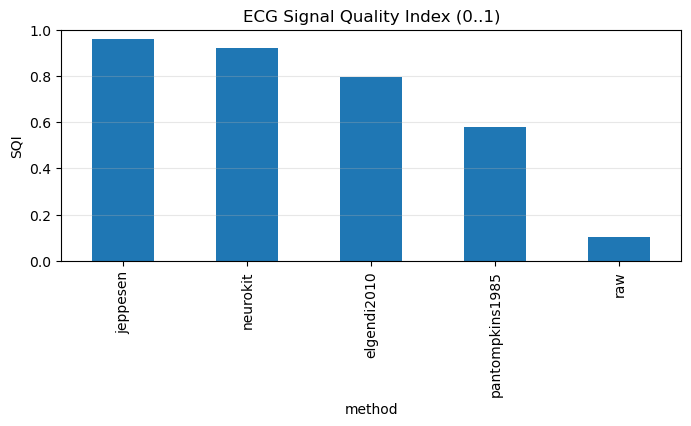

In [12]:
def ecg_sqi_for_signals(signals: dict, fs: float, weights=None):
    rows = []
    for name, sig in signals.items():
        out = ecg_sqi(sig, fs, weights=weights, return_dict=True)
        rows.append({
            "method": name,
            "SQI": out["score"],
            **{f"c_{k}": v for k,v in out["components"].items()},
            **out["metrics"]
        })
    df = pd.DataFrame(rows).set_index("method").sort_values("SQI", ascending=False)
    return df

df_sqi = ecg_sqi_for_signals(signals, fs)
display(df_sqi)

# Hurtigt bar-plot
import matplotlib.pyplot as plt
ax = df_sqi["SQI"].plot.bar(figsize=(8,3), title="ECG Signal Quality Index (0..1)")
ax.set_ylabel("SQI"); ax.set_ylim(0,1); ax.grid(True, axis="y", alpha=0.3)
plt.show()


In [13]:
import numpy as np
import pandas as pd

def _segments(n, fs, window_s=10.0, step_s=2.0):
    """Returnér liste af (i0,i1) indeks for overlappende vinduer."""
    w = int(round(window_s * fs))
    s = int(round(step_s * fs))
    if w <= 1: 
        return [(0, n)]
    edges = []
    i0 = 0
    while i0 < n:
        i1 = min(n, i0 + w)
        edges.append((i0, i1))
        if i1 == n: break
        i0 += s
    return edges

def ecg_sqi_segmented(signal, fs, window_s=10.0, step_s=2.0,
                      weights=None, line_band=(49.0, 51.0),
                      aggregate="mean", return_details=True):
    """
    Beregn SQI pr segment og map det til et pr-sample array.
    - window_s/step_s: glidende vindue (typisk 8–12 s, step 1–2 s)
    - aggregate: 'mean' (default), 'max' eller 'last' for samples der dækkes af flere vinduer
    Returnerer:
      sqi_samples: np.ndarray (len=N) med SQI pr sample
      df: DataFrame med segment-scorer og delkomponenter (optionelt)
    """
    x = np.asarray(signal, float)
    n = len(x)
    segs = _segments(n, fs, window_s, step_s)

    # container til pr-sample mapping
    sqi_samples = np.zeros(n, dtype=float)
    counts = np.zeros(n, dtype=int)

    rows = []
    for (i0, i1) in segs:
        out = ecg_sqi(x[i0:i1], fs, line_band=line_band, weights=weights, return_dict=True)
        score = out["score"]
        # map til samples i segmentet
        if aggregate == "max":
            sqi_samples[i0:i1] = np.maximum(sqi_samples[i0:i1], score)
            counts[i0:i1] = np.maximum(counts[i0:i1], 1)
        elif aggregate == "last":
            sqi_samples[i0:i1] = score
            counts[i0:i1] = 1
        else:  # mean
            sqi_samples[i0:i1] += score
            counts[i0:i1] += 1

        rows.append({
            "start_s": i0 / fs,
            "end_s":   i1 / fs,
            "center_s": (i0 + i1) / (2*fs),
            "SQI": score,
            **{f"c_{k}": v for k,v in out["components"].items()},
            **out["metrics"]
        })

    if aggregate == "mean":
        counts[counts == 0] = 1
        sqi_samples = sqi_samples / counts

    df = pd.DataFrame(rows).sort_values("start_s").reset_index(drop=True) if return_details else None
    return (sqi_samples, df) if return_details else sqi_samples


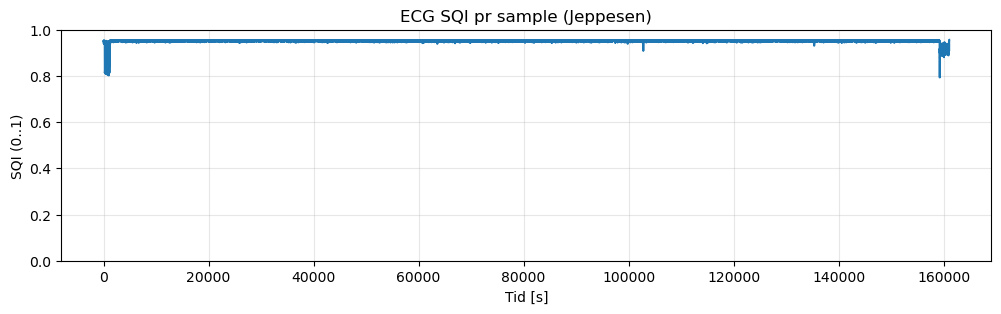

In [14]:
# pr-sample SQI (10 s vinduer, 2 s step)
sqi_samples, df_segments = ecg_sqi_segmented(clean_jepp, fs, window_s=10, step_s=2)

# plot som tidsserie (hurtigt)
import matplotlib.pyplot as plt
t = np.arange(len(sqi_samples))/fs
plt.figure(figsize=(12,3))
plt.plot(t, sqi_samples); plt.ylim(0,1); plt.grid(True, alpha=0.3)
plt.title("ECG SQI pr sample (Jeppesen)"); plt.xlabel("Tid [s]"); plt.ylabel("SQI (0..1)")
plt.show()

# sammenlign segment-SQI fordelt på metoder:
dfs = []
for name, sig in signals.items():
    sqi_s, df_seg = ecg_sqi_segmented(sig, fs, window_s=10, step_s=2)
    df_seg["method"] = name
    dfs.append(df_seg)
df_all = pd.concat(dfs, ignore_index=True)


In [15]:
print(df_all.groupby("method")["SQI"].describe().T)

method   elgendi2010      jeppesen      neurokit  pantompkins1985  \
count   80524.000000  80524.000000  80524.000000     80524.000000   
mean        0.946397      0.950773      0.942803         0.941630   
std         0.042470      0.010806      0.023662         0.054732   
min         0.327970      0.776039      0.584304         0.304838   
25%         0.950155      0.950195      0.944330         0.948368   
50%         0.950179      0.953125      0.948681         0.949970   
75%         0.953099      0.953125      0.951035         0.952705   
max         0.957146      0.956217      0.953121         0.953065   

method           raw  
count   80524.000000  
mean        0.585113  
std         0.099492  
min         0.000000  
25%         0.517547  
50%         0.590363  
75%         0.665452  
max         0.800897  
